In [1]:
#IMPORT NECESSARY PACKAGES
import numpy as np
import matplotlib.pyplot as plt
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from mpl_toolkits.axes_grid1 import ImageGrid
import networkx as nx
from matplotlib import ticker
import pickle as P
import os

markersize = 4

In [2]:
#XOR
X_xor = np.array([[0,0],[0,1],[1,0],[1,1]])
Y_xor = np.array([[0],[1],[1],[0]])

#AND
X_and = np.array([[0,0],[0,1],[1,0],[1,1]])
Y_and = np.array([[0],[0],[0],[1]])

#OR
X_or = np.array([[0,0],[0,1],[1,0],[1,1]])
Y_or = np.array([[0],[1],[1],[1]])

#NOT
X_not = np.array([[0],[1]])
Y_not = np.array([[1],[0]])

#IDENTITY
X_id = np.array([[0],[1]])
Y_id = np.array([[0],[1]])

In [3]:
#DEFINE AUXILIARY FUNCTIONS

#shape/constrain the matrix of synaptic weights and biases
def constrain_weights(W,B,N_X,N_H,N_Y):
    #no self-loops
    for i in range(len(W)):
        W[i,i] = 0
    #no intra-input connections
    W[:N_X,:N_X] = 0
    #no incoming connections to input or bias neurons
    W[N_X:,:N_X] = 0
    B[:N_X] = 0
    return W,B

#hard-sigmoid bounding function
def hard_sigmoid(x,deriv=False):
    if not deriv:
        return np.clip(x,0,1)
    return (1-np.heaviside(x-1,0))*np.heaviside(x,0)

#weights initialization
def weigths_init(n):
    W_values = np.random.normal(0,0.05,(n,n))
    B_values = np.random.normal(0,0.05,n)
    B_values = np.array([0]*n).astype(float)
    return W_values,B_values

#states initialization
def states_init(m,n):
    s_values = np.random.uniform(0,0.1,(m,n))
    return s_values

#get prediction labels from the output (y_out<0.5 => y_pred=0 and y_out>0.5 => y_pred=1)
def get_predictions(y_out):
    y_pred = np.heaviside(y_out-0.5,1)
    return y_pred

#average classification error (number of unequal predictions)
def avg_neq(x,y):
    r = 0
    for i in range(len(x)):
        r += int(x[i]!=y[i])
    return r/len(x)

In [4]:
#DEFINE THE TRAINING ALGORITHM
def train(X_train,Y_train,regularized,sparse,hyper=dict()):
    
    #extract parameters from dictionary hyper
    N_H      = hyper["N_H"]
    n_epochs = hyper["n_epochs"]
    T1       = hyper["T1"]
    T2       = hyper["T2"]
    dt       = hyper["dt"]
    stop     = hyper["stop"]
    beta     = hyper["beta"]
    dt_W     = hyper["dt_W"]
    beta_0   = hyper["beta_0"]
    beta_1   = hyper["beta_1"]
    reg_W    = hyper["reg_W"]
    tol_W    = hyper["tol_W"]
    temp     = hyper["temp"]
    
    #keep important dimensions
    N_X = len(X_train[0])
    N_Y = len(Y_train[0])
    N = N_X+np.sum(N_H)+N_Y
    
    #initialize synaptic weights and biases
    W,B = weigths_init(N)
    W,B = constrain_weights(W,B,N_X,N_H,N_Y)
    
    #create lists of important parameters to keep for analysis
    S_epochs = np.zeros((n_epochs,T1+T2+1,len(X_train),N))
    S_free = np.zeros((len(X_train),N))
    S_weak = np.zeros((len(X_train),N))
    errors_free = np.zeros((n_epochs,T1))
    errors_weak = np.zeros((n_epochs,T2))
    mses_free = np.zeros((n_epochs,T1))
    mses_weak = np.zeros((n_epochs,T2))
    errors_class_free = np.zeros(n_epochs)
    errors_class_weak = np.zeros(n_epochs)
    W_epochs = [W.copy()]
    dW_epochs = []
    B_epochs = [B.copy()]
    dB_epochs = []

    for epoch in range(n_epochs):
        print("[{}/{}]".format(epoch+1,n_epochs),end="\r")
        
        #initialize neuronal activity
        s_aux = states_init(len(X_train),np.sum(N_H)+N_Y)
        S = np.concatenate((X_train,s_aux),axis=1)
        S_epochs[epoch,0] = S.copy()
        
        #run the 1st phase (update neuronal activity)
        error_free = np.zeros(T1)
        mse_free = np.zeros(T1)
        for t1 in range(T1):
            dS = S@W+B-S
            S[:,N_X:] += dt*dS[:,N_X:]
            S[:,N_X:] = hard_sigmoid(S[:,N_X:])
            S_epochs[epoch,(1+t1)] = S.copy()
            error_free[t1] = np.sum(dS[:,N_X:]**2)
            mse_free[t1] = np.sum((S[:,-N_Y:]-Y_train)**2)/2
        errors_free[epoch] = error_free/len(X_train)
        mses_free[epoch] = mse_free/len(X_train)
        Y_pred = get_predictions(S[:,-N_Y:])
        class_error = avg_neq(Y_pred,Y_train)
        errors_class_free[epoch] += class_error
        S_free = S.copy()

        #run the 2nd phase (update neuronal activity)
        error_weak = np.zeros(T2)
        mse_weak = np.zeros(T2)
        S_trajectory = np.zeros((T2+1,len(X_train),N))
        S_trajectory[0] = S.copy()
        for t2 in range(T2):
            dS = S@W+B-S
            dS[:,-N_Y:] += beta*(Y_train-S[:,-N_Y:])      
            S[:,N_X:] += dt*dS[:,N_X:]
            S[:,N_X:] = hard_sigmoid(S[:,N_X:])
            S_epochs[epoch,(1+T1+t2)] = S.copy()
            S_trajectory[t2+1] = S.copy()
            error_weak[t2] = np.sum(dS[:,N_X:]**2)
            mse_weak[t2] = np.sum((S[:,-N_Y:]-Y_train)**2)/2
        errors_weak[epoch] = error_weak/len(X_train)
        mses_weak[epoch] = mse_weak/len(X_train)
        Y_pred = get_predictions(S[:,-N_Y:])
        class_error = avg_neq(Y_pred,Y_train)
        errors_class_weak[epoch] += class_error
        S_weak = S.copy()
        
        #update synaptic weights and biases
        dW = np.zeros_like(W)
        dB = np.zeros_like(B)
        
        for i in range(len(X_train)):
            dW += np.outer(np.array(S_free)[i], np.array(S_weak)[i]-np.array(S_free)[i])
            dB += np.array(S_weak)[i]-np.array(S_free)[i]
        dW /= (beta*len(X_train))
        dB /= (beta*len(X_train))
        
        r_W = np.zeros_like(W)
        #weights regularization
        if regularized:
            #regularization L_1
            r_W = -reg_W*np.sign(W)
                
        W += dt_W*dW+r_W
        B += dt_W*dB
        W,B = constrain_weights(W,B,N_X,N_H,N_Y)
        
        #stochastic sparsification
        if sparse:
            #calculate indexes of strong connections (the ones that surely remain in the network)
            mask = ((W<-tol_W)|(W>tol_W))
            #calculate probability of removing each weak connection (across incoming connections of every nneuron)
            probs = np.exp(-np.abs(W)/temp)/np.sum(np.exp(-np.abs(W)/temp),axis=0)
            #strong connections are never removed (prob_removal=0)
            probs[mask] = 0
            #promote sparse network by randomly removing the connections with higher probabilities of being removed (probs)
            random = np.random.random_sample(probs.shape)
            change = ((probs>random)&(probs!=0))
            #remove connections deemed irrelevant
            W[change] = 0
        
        W_epochs.append(W.copy())
        dW_epochs.append(dt_W*dW.copy())
        B_epochs.append(B.copy())
        dB_epochs.append(dt_W*dB.copy())
    
    W_epochs = np.array(W_epochs)
    dW_epochs = np.array(dW_epochs)
    B_epochs = np.array(B_epochs)
    dB_epochs = np.array(dB_epochs)
    
    return S_epochs,S_free,S_weak,errors_free,errors_weak,mses_free,mses_weak,errors_class_free,errors_class_weak,W_epochs,dW_epochs,B_epochs,dB_epochs

In [9]:
#DEFINE TAKS TO LEARN (AND/OR/XOR/NOT/ID)
X_train = X_xor
Y_train = Y_xor

#DEFINE PARAMETERS GIVEN TO THE NETWORK
#reglarization parameters
regularized = False
sparse = False

#dictionary with hyperparameters given to the network
hyper = {
#number of hidden neurons (given by layer -- if layered -- or number of neurons -- if not layered)
"N_H"      : [5],
#number of epochs
"n_epochs" : 200,
#number of 1st phase iterations
"T1"       : 1000,
#number of 2nd phase iterations
"T2"       : 1000,
#learning step of the state variable
"dt"       : 0.05,
#near-equilibrium relaxation parameter
"stop"     : 1e-10,
#clamping factor
"beta"     : 10,
#learning step for the synaptic weights
"dt_W"     : 1,
#STDP parameters
"beta_0"   : 0,
#STDP parameters
"beta_1"   : 1,
#influence of the L_1 regularization term in the weight dynamics
"reg_W"    : 0.00015,
#threshold bellow which the synaptic weights are considered for removal
"tol_W"    : 0.01,
#temperature of the Bolzmann distribution used for sparsification
"temp"     : 5
}

#choose number of models to be trained
num_net = 10

In [10]:
#MODEL(s)-train---------------------------------------------------
avg_mse_train_epoch = np.zeros((num_net,hyper["n_epochs"]))

for n in range(num_net):
    output = train(X_train,Y_train,regularized,sparse,hyper)
    mses_free = output[5]
    avg_mse_train_epoch[n] = mses_free[:,-1]

S_epochs          = output[0]
S_free            = output[1]
S_weak            = output[2]
errors_free       = output[3]
errors_weak       = output[4]
mses_free         = output[5]
mses_weak         = output[6]
errors_class_free = output[7]
errors_class_weak = output[8]
W_epochs          = output[9]
dW_epochs         = output[10]
B_epochs          = output[11]
dB_epochs         = output[12]


#save last trained model and average MSE per training epoch for every model
if os.path.isfile("net_EP_asym.save")>0:
    os.remove("net_EP_asym.save")
if not os.path.isfile("net_EP_asym.save"):
    file = open("net_EP_asym.save","x")
    file.close()
file = open("net_EP_asym.save","wb")
to_dump = X_train,Y_train,hyper,avg_mse_train_epoch,S_epochs,S_free,S_weak,errors_free,errors_weak,mses_free,mses_weak,errors_class_free,errors_class_weak,W_epochs,dW_epochs,B_epochs,dB_epochs
P.dump(to_dump,file,protocol=P.HIGHEST_PROTOCOL)
P.dump(to_dump,file,protocol=P.HIGHEST_PROTOCOL)
file.close()

<h2><center> IF NETWORK ALREADY TRAINED (START HERE)

In [11]:
#NET-read---------------------------------------------------
file = open("net_EP_asym.save",'rb')
net = P.load(file)
file.close()

X_train             = net[0]
Y_train             = net[1]
hyper               = net[2]
avg_mse_train_epoch = net[3]
S_epochs            = net[4]
S_free              = net[5]
S_weak              = net[6]
errors_free         = net[7]
errors_weak         = net[8]
mses_free           = net[9]
mses_weak           = net[10]
errors_class_free   = net[11]
errors_class_weak   = net[12]
W_epochs            = net[13]
dW_epochs           = net[14]
B_epochs            = net[15]
dB_epochs           = net[16]

#extract parameters from dictionary hyper
N_H      = hyper["N_H"]
n_epochs = hyper["n_epochs"]
T1       = hyper["T1"]
T2       = hyper["T2"]
dt       = hyper["dt"]
beta     = hyper["beta"]
dt_W     = hyper["dt_W"]
beta_0   = hyper["beta_0"]
beta_1   = hyper["beta_1"]
reg_W    = hyper["reg_W"]
tol_W    = hyper["tol_W"]
temp     = hyper["temp"]

#number of input neurons
N_X = len(X_train[0])
#number of output neurons
N_Y = len(Y_train[0])
#total number of neurons 
N = N_X+np.sum(N_H)+N_Y
#synaptic weights and biases learned
W = W_epochs[-1]
B = B_epochs[-1]

In [12]:
#PRINT RESULTS OF TRAINED MODEL
#true labels
print("Y_train: {}\n".format(Y_train.T[0]))
#output neurons' values in 1st and 2nd phases
print("Y_out_free: {}".format(S_free[:,-N_Y]))
print("Y_out_weak: {}\n".format(S_weak[:,-N_Y]))
#predicted labels in 1st and 2nd phases
print("Y_pred_free: {}".format(get_predictions(S_free[:,-N_Y])))
print("Y_pred_weak: {}\n".format(get_predictions(S_weak[:,-N_Y])))

#minimum and maximum synaptic weights
print("W_min = {:.3f}, W_max = {:.3f}".format(np.min(W_epochs),np.max(W_epochs)))
#MSE reached in 1st and 2nd phases after convergence
print("MSE_free_last = {:.3f}, MSE_weak_last = {:.3f}".format(mses_free[-1,-1],mses_weak[-1,-1]))
#classification error in 1st and 2nd phases after convergence
print("Class_error_free_last = {:.3%}, Class_error_weak_last = {:.3%}\n".format(errors_class_free[-1],errors_class_weak[-1]))

#VERIFY COVERGENCE GUARANTEES OF THE INFERENCE PHASE (1st phase)
#sum of absolute values of weights by column for i,j=P+1,...,N (sum row elements of Jacobian matrix)
b1_row = np.sum(np.abs(W)[N_X:,N_X:],axis=0)
#sum of absolute values of weights by row for i,j=P+1,...,N (sum column elements of Jacobian matrix)
b1_column = np.sum(np.abs(W)[N_X:,N_X:],axis=1)
#verify condition (by row)
second_row = np.all(b1_row<1)
#verify condition (by column)
second_column = np.all(b1_column<1)

fails_by_row = np.count_nonzero((b1_row>1))
fails_by_column = np.count_nonzero((b1_column>1))

print("Gershgorin by row: {} (fails in {} rows)".format(second_row,fails_by_row))
print("Gershgorin by column: {} (fails in {} columns)".format(second_column,fails_by_column))

Y_train: [0 1 1 0]

Y_out_free: [0.48523279 0.49830298 0.49816662 0.50949755]
Y_out_weak: [0.04410645 0.95439569 0.95438376 0.04629907]

Y_pred_free: [0. 0. 0. 1.]
Y_pred_weak: [0. 1. 1. 0.]

W_min = -0.151, W_max = 0.158
MSE_free_last = 0.125, MSE_weak_last = 0.001
Class_error_free_last = 75.000%, Class_error_weak_last = 0.000%

Gershgorin by row: True (fails in 0 rows)
Gershgorin by column: True (fails in 0 columns)


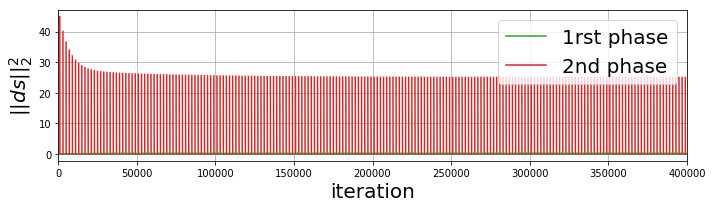

In [13]:
#PLOT COVERGENCE OF THE NEURONAL DYNAMICS ACROSS ITERATIONS FOR 1ST AND 2ND PHASES
f,ax = plt.subplots(1,1,figsize=(10,3),sharex=True)
plt.xlim(0,n_epochs*(T1+T2))
for i,(error_free,error_weak) in enumerate(zip(errors_free,errors_weak)):
    free_xs = range(i*T1+i*T2,(i+1)*T1+i*T2)
    weak_xs = range(i*T2+(i+1)*T1,(i+1)*T2+(i+1)*T1)
    im = ax.plot(free_xs,error_free,c=default_colors[2],markersize=markersize)
    im = ax.plot(weak_xs,error_weak,c=default_colors[3],markersize=markersize)
#     ax.set_title("(a)",fontsize=30,y=1.01)
    ax.legend((r"1rst phase",r"2nd phase"),loc="upper right",fontsize=20)
    ax.set_xlabel("iteration",fontsize=20)
    ax.set_ylabel(r"$||ds||^2_2$",fontsize=20)

ax.grid()
plt.tight_layout()
plt.savefig("dS_EP_asym.pdf",dpi=200,transparent=True)
plt.show()

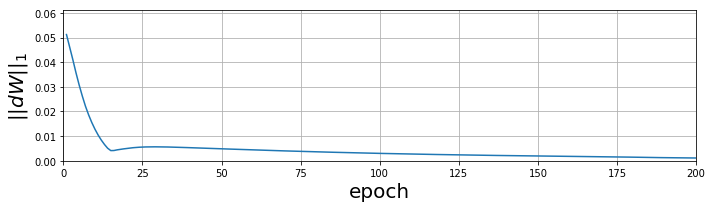

In [14]:
#PLOT COVERGENCE OF THE WEIGHT DYNAMICS ACROSS EPOCHS
f,ax = plt.subplots(1,1,figsize=(10,3),sharex=True)
plt.xlim(0,n_epochs)
xs = np.arange(1,hyper["n_epochs"]+1,1)
dW_epochs_norm = np.sum(np.abs(dW_epochs),axis=(1,2))
ax.plot(xs,dW_epochs_norm,"-",markersize=markersize)
# ax.set_title("(b)",fontsize=30,y=1.01)
ax.set_xlabel("epoch",fontsize=20)
ax.set_ylabel(r"$||dW||_1$",fontsize=20)
ax.set_ylim(0,np.max(dW_epochs_norm)+0.01)
ax.grid()

plt.tight_layout()
plt.savefig("dW_EP_asym.pdf",dpi=200,transparent=True)
plt.show()

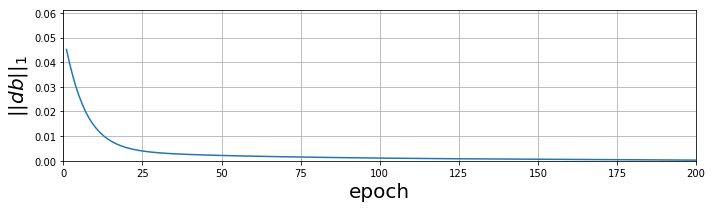

In [15]:
#PLOT COVERGENCE OF THE WEIGHT DYNAMICS ACROSS EPOCHS
f,ax = plt.subplots(1,1,figsize=(10,3),sharex=True)
plt.xlim(0,n_epochs)
xs = np.arange(1,hyper["n_epochs"]+1,1)
dB_epochs_norm = np.sum(np.abs(dB_epochs),axis=1)
ax.plot(xs,dB_epochs_norm,"-",markersize=markersize)
# ax.set_title("(c)",fontsize=30,y=1.01)
ax.set_xlabel("epoch",fontsize=20)
ax.set_ylabel(r"$||db||_1$",fontsize=20)
ax.set_ylim(0,np.max(dW_epochs_norm)+0.01)
ax.grid()

plt.tight_layout()
plt.savefig("db_EP_asym.pdf",dpi=200,transparent=True)
plt.show()

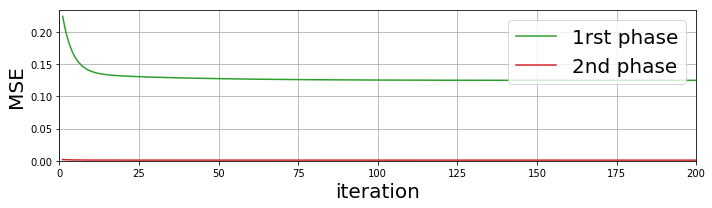

In [16]:
#PLOT COVERGENCE OF THE MSE ACROSS ITERATIONS FOR 1ST AND 2ND PHASES
f,ax = plt.subplots(1,1,figsize=(10,3),sharex=True)
plt.xlim(0,n_epochs)
xs = np.arange(1,hyper["n_epochs"]+1,1)
ax.plot(xs,mses_free[:,-1],"-",c=default_colors[2],markersize=markersize)
ax.plot(xs,mses_weak[:,-1],"-",c=default_colors[3],markersize=markersize)
# ax.set_title("(d)",fontsize=30,y=1.01)
ax.legend((r"1rst phase",r"2nd phase"),loc="upper right",fontsize=20)
ax.set_xlabel("iteration",fontsize=20)
ax.set_ylabel("MSE",fontsize=20)
ax.set_ylim(0,np.max((np.max(mses_free[:,-1]),np.max(mses_weak[:,-1])))+0.01)
ax.grid()

plt.tight_layout()
plt.savefig("MSE_EP_asym.pdf",dpi=200,transparent=True)
plt.show()

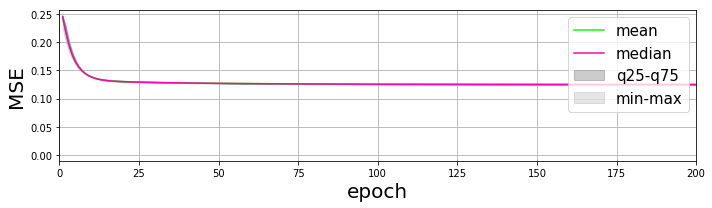

In [17]:
#PLOT COVERGENCE OF THE MSE ACROSS EPOCHS FOR 1ST AND 2ND PHASES
f,ax = plt.subplots(1,1,figsize=(10,3),sharex=True)
plt.xlim(0,n_epochs)
xs = np.arange(1,hyper["n_epochs"]+1,1)

mean        = np.mean(avg_mse_train_epoch,axis=0)
median      = np.median(avg_mse_train_epoch,axis=0)
minimum     = np.min(avg_mse_train_epoch,axis=0)
maximum     = np.max(avg_mse_train_epoch,axis=0)
q25         = np.percentile(avg_mse_train_epoch,25,axis=0)
q75         = np.percentile(avg_mse_train_epoch,75,axis=0)

y_max = np.max(maximum)

ax.plot(xs,mean,label="mean",c="#0cff0c",zorder=5)
ax.plot(xs,median,label="median",c="#fe01b1",zorder=5)
ax.fill_between(xs,q75,q25,label="q25-q75",color=(0,0,0,0.2))
ax.fill_between(xs,maximum,minimum,label="min-max",color=(0,0,0,0.1))
ax.grid()
ax.set_ylim(0-0.01,y_max+0.01)
ax.legend(loc="upper right",fontsize=15)
ax.set_xlabel("epoch",fontsize=20)
ax.set_ylabel("MSE",fontsize=20)
# ax.set_title("(e)",y=1.01,fontsize=30)

plt.tight_layout()
plt.savefig("MSE_measures_EP_asym.pdf",dpi=200,transparent=True)
plt.show()

c:\users\matil\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


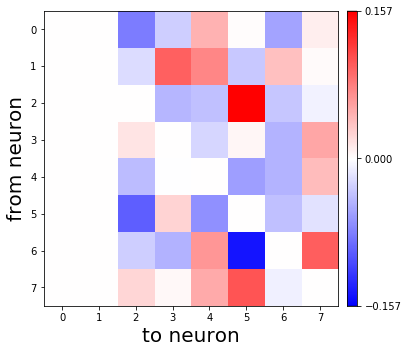

In [18]:
#PLOT MATRIX CONTAINING THE SYNAPTIC WEIGHTS
cmin, cmax = np.min(W),np.max(W)
clim = np.max([np.abs(cmin),np.abs(cmax)])
W_dim = len(W)
W_plot = W.copy()

#change bias to be the first entry in the matrix
if N_X==3:
    W_plot[0,:] = W[N_X-1,:].copy()
    W_plot[N_X-2,:] = W[0,:].copy()
    W_plot[N_X-1,:] = W[N_X-2,:].copy()
    W_plot[:,0] = W[:,N_X-1].copy()
    W_plot[:,N_X-2] = W[:,0].copy()
    W_plot[:,N_X-1] = W[:,N_X-2].copy()
if N_X==2:
    W_plot[0,:] = W[N_X-1,:].copy()
    W_plot[N_X-1,:] = W[0,:].copy()
    W_plot[:,0] = W[:,N_X-1].copy()
    W_plot[:,N_X-1] = W[:,0].copy()

fig = plt.figure(figsize=(6,5))
grid = ImageGrid(fig,111,
                 nrows_ncols=(1,1),
                 axes_pad=1.0,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3.5%",
                 cbar_pad=0.12,)
[ax] = grid

im = ax.imshow(W_plot,cmap="bwr",vmin=-clim,vmax=clim)
ax.set_xticks(np.arange(0,N))
ax.set_yticks(np.arange(0,N))
ax.set_xlabel("to neuron",fontsize=20)
ax.set_ylabel("from neuron",fontsize=20)

#colorbar
ax.cax.colorbar(im,ticks=np.linspace(-clim,clim,3))
ax.cax.toggle_label(True)

# ax.set_title("(a)",y=1.01,fontsize=30)
plt.tight_layout()
plt.savefig("W_EP_asym.pdf",dpi=200,transparent=True)
plt.show()

In [19]:
#TEST THE MODEL FOR A BATCH INPUT
def test_predcitions(X,N_X,N_H,N_Y):
    s_t = np.random.uniform(0,0.1,(len(X),np.sum(N_H)+N_Y))
    S_t = np.concatenate((X,s_t),axis=1)
    for t1 in range(T1):
        dS_t = S_t@W+B-S_t
        S_t[:,N_X:] += dt*dS_t[:,N_X:]
        S_t[:,N_X:] = hard_sigmoid(S_t[:,N_X:])
    return S_t

In [20]:
#MODEL-test---------------------------------------------------
S_t = test_predcitions(X_train,N_X,N_H,N_Y)
#output neurons' values in 1st and 2nd phases
print("Y_out_free: {}".format(S_t[:,-N_Y]))
#predicted labels in 1st and 2nd phases
print("Y_pred_free: {}".format(get_predictions(S_t[:,-N_Y])))

Y_out_free: [0.48543375 0.49832566 0.49821381 0.50936072]
Y_pred_free: [0. 0. 0. 1.]


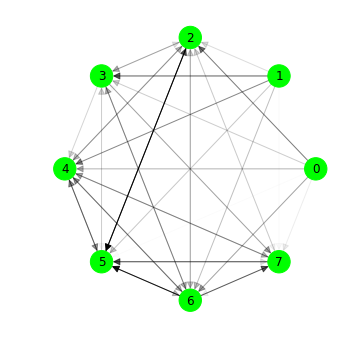

In [21]:
#PLOT NETWORK
f,ax = plt.subplots(1,1,figsize=(5,5))
num_class = 1
#comment if you do not want to plot the bias neuron
W_aux = W_plot[1:,1:]

G_dir = nx.from_numpy_matrix(W_plot,create_using=nx.DiGraph)
#comment if you do not want to plot the bias neuron
# G_dir = nx.from_numpy_matrix(W_aux,create_using=nx.DiGraph)

num_fixed_zero = N_X**2+num_class+np.sum(N_H)+N_X*(num_class+np.sum(N_H))
#comment if you do not want to plot the bias neuron
# num_fixed_zero = (N_X-1)**2+num_class+np.sum(N_H)+(N_X-1)*(num_class+np.sum(N_H))

maximum = np.max(np.abs(W_plot))
#comment if you do not want to plot the bias neuron
# maximum = np.max(np.abs(W_aux))

ws = []
for u in G_dir:
    for v in G_dir[u]:
        ws.append(G_dir[u][v]['weight'])
        
sparsity = 1-len(ws)/(len(G_dir)**2-num_fixed_zero)

G_edge_colors = [(0,0,0,np.abs(w)/maximum) for w in ws]
G_node_colors = [(0,1,0,0)]*len(W_plot[0])

#degree with respect to incoming edges
d = nx.degree(G_dir)
d_out = np.array(G_dir.out_degree(G_dir.nodes))[:,1]

nx.draw_circular(G_dir,with_labels=True,node_shape='o',ax=ax,edge_color=G_edge_colors,node_color=G_node_colors,node_size=500,arrowsize=15)

# ax.set_title("(b) sparsity = {:.2%}".format(sparsity),y=1,fontsize=25)
plt.tight_layout()
plt.savefig("network_EP_asym.pdf",dpi=200,transparent=True)
plt.show()

<h2><center> PLOT DECISION MAPS

In [22]:
#TEST MODEL FOR ONE INPUT
def test_predcition(x,N_X,N_H,N_Y):
    s = np.random.uniform(0,0.1,np.sum(N_H)+N_Y)
    S = np.concatenate((x,s))
    for t1 in range(T1):
        dS = S@W+B-S
        S[N_X:] += dt*dS[N_X:]
        S[N_X:] = hard_sigmoid(S[N_X:])
    return S[-1]

In [23]:
#DECISION MAP-compute---------------------------------------------------
#number of points in [0,1]
n = 100
data_size  = len(X_train)
X_heat = np.linspace(0,1,n+1)
predictions = np.zeros((len(X_heat),len(X_heat)))

for i,x_1 in enumerate(X_heat):
    for j,x_2 in enumerate(X_heat):
        x = np.array([x_1,x_2])
        y = test_predcition(x,N_X,N_H,N_Y)
        predictions[i,j] = y

In [24]:
if os.path.isfile("decision_map_EP_asym.save")>0:
    os.remove("decision_map_EP_asym.save")
if not os.path.isfile("decision_map_EP_asym.save"):
    file = open("decision_map_EP_asym.save","x")
    file.close()
file = open("decision_map_EP_asym.save","wb")
to_dump = n,X_heat,predictions
P.dump(to_dump,file,protocol=P.HIGHEST_PROTOCOL)
file.close()

c:\users\matil\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


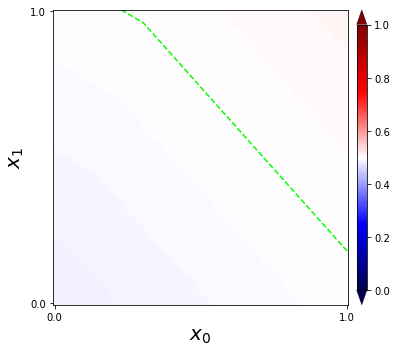

In [25]:
#PLOT DECISION MAP
file = open("decision_map_EP_asym.save",'rb')
net = P.load(file)
file.close()

n           = net[0]
X_heat      = net[1]
predictions = net[2]

y_min = np.min(predictions)
y_max = np.max(predictions)

fig = plt.figure(figsize=(6,5))
grid = ImageGrid(fig,111,
                 nrows_ncols=(1,1),
                 axes_pad=1.0,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3.5%",
                 cbar_pad=0.12,)
[ax] = grid
clim = np.max([np.abs(y_min),np.abs(y_max)])

#plot decision boundary as green dashed line
im = ax.contour(predictions.T,linestyles="dashed",origin="lower",levels=0.5,colors=[(0,1,0,1)],vmin=0,vmax=1)
#plot decision map
im = ax.imshow(predictions.T,cmap='seismic',origin='lower',vmin=0,vmax=1)
plt.sca(ax)
ax.set_xlabel(r"$x_0$",fontsize=20)
ax.set_ylabel(r"$x_1$",fontsize=20)
plt.xticks(np.linspace(0,n,2),[0.0,1.0])
plt.yticks(np.linspace(0,n,2),[0.0,1.0])

#colorbar
ax.cax.colorbar(im,extend='both')
ax.cax.toggle_label(True)

# ax.set_title("(c)",y=1.01,fontsize=30)
plt.savefig("decision_map_EP_asym.pdf",dpi=200,transparent=True)
plt.tight_layout()
plt.show()